 # MNIST with pytorch

In [3]:
import torch
import numpy
import matplotlib.pyplot as plt
import torch.nn as nn

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [5]:
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

## Load the data

In [6]:
#batch_size = 8192
batch_size = 14745
validation_size = 10000

I onyl have 2gb of VRAM so i am using a smaller batch_size to fit the data in the VRAM

In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0, 1)])

I will normalize the data so that it means is zero and it variance 1 because i don't find how to fit my data to [0,1]

In [8]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,transform=transforms)
mnist_trainset,mnist_valset = torch.utils.data.random_split(mnist_trainset, [len(mnist_trainset)-10000,10000])
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,transform=transforms)

In [9]:
mnist_trainset[0][0].shape

torch.Size([1, 28, 28])

In [10]:
mnist_trainset

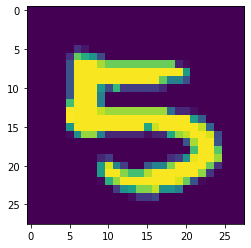

In [11]:
plt.imshow(mnist_trainset[0][0][0])

In [12]:
train_loader = DataLoader(
    mnist_trainset,
    num_workers=2,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    mnist_valset,
    num_workers=2,
    batch_size=len(mnist_valset),
    shuffle=True
)

test_loader = DataLoader(
    mnist_testset,
    num_workers=2,
    batch_size=len(mnist_testset),
    shuffle=True
)

In [13]:
batch_idx, (example_data, example_targets) = next(enumerate(train_loader))

In [14]:
example_data.shape

torch.Size([14745, 1, 28, 28])

## define the neural net

### Model 1

In [100]:
class Model1(nn.Module):
    def __init__(self,midel_layer):
        super().__init__()
        self.linear1 = nn.Linear(28*28,50) 
        nn.init.xavier_uniform_(self.linear1.weight)
        
        self.linear2 = nn.Linear(50,midel_layer)
        nn.init.xavier_uniform_(self.linear2.weight)
        
        self.linear3 = nn.Linear(midel_layer,28*28)
        nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        original_shape = x.shape
        x = x.view(-1,28*28)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
    
        x = x.view(original_shape)
        
        return x

In [77]:
model1 = Model1(2)
model2 = Model1(4)
model2.to(device),model1.to(device)

(Model1(
   (linear1): Linear(in_features=784, out_features=50, bias=True)
   (linear2): Linear(in_features=50, out_features=4, bias=True)
   (linear3): Linear(in_features=4, out_features=784, bias=True)
 ),
 Model1(
   (linear1): Linear(in_features=784, out_features=50, bias=True)
   (linear2): Linear(in_features=50, out_features=2, bias=True)
   (linear3): Linear(in_features=2, out_features=784, bias=True)
 ))

In [78]:
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-4)

loss_func = nn.MSELoss()

In [79]:
losses_train1 = []
losses_val1 = []
losses_train2 = []
losses_val2 = []

In [80]:
epochs = 800
val_frequency = 10

In [81]:
%%time
model1.to(device)
model2.to(device)
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        data = data.to(device)
        output1 = model1(data)
        output2 = model2(data)

        loss1 = loss_func(output1, data)
        loss2 = loss_func(output2, data)

        loss1.backward()
        optimizer1.step()
        
        loss2.backward()
        optimizer2.step()



    if (epoch == 0 or epoch%val_frequency == 0 or epoch == epochs-1):

        with torch.no_grad():
            _,(val_data, _) = next(enumerate(val_loader))
            val_data = val_data.to(device)
            output_val1 = model1(val_data)
            loss_val1 = loss_func(output_val1, val_data)
            output_val2 = model2(val_data)
            loss_val2 = loss_func(output_val2, val_data)
            
            
            
            
        losses_train1.append(loss1.item())
        losses_val1.append(loss_val1.item())
        losses_train2.append(loss2.item())
        losses_val2.append(loss_val2.item())
        print(f"Epoch {epoch}, loss_val1 {loss_val1.item()}, loss_val1 {loss_val2.item()}")


Epoch 0, loss_val1 0.15252292156219482, loss_val1 0.12237241864204407
Epoch 10, loss_val1 0.15070876479148865, loss_val1 0.12089990824460983
Epoch 20, loss_val1 0.14744429290294647, loss_val1 0.11850091814994812
Epoch 30, loss_val1 0.14310681819915771, loss_val1 0.11315318942070007
Epoch 40, loss_val1 0.13485388457775116, loss_val1 0.10478381812572479
Epoch 50, loss_val1 0.12413661926984787, loss_val1 0.09661591053009033
Epoch 60, loss_val1 0.1140591949224472, loss_val1 0.09045272320508957
Epoch 70, loss_val1 0.10605023801326752, loss_val1 0.08603409677743912
Epoch 80, loss_val1 0.09973322600126266, loss_val1 0.08294349163770676
Epoch 90, loss_val1 0.09509333968162537, loss_val1 0.08109890669584274
Epoch 100, loss_val1 0.09154972434043884, loss_val1 0.07991166412830353
Epoch 110, loss_val1 0.08865758776664734, loss_val1 0.07913761585950851
Epoch 120, loss_val1 0.0863180011510849, loss_val1 0.07834897935390472
Epoch 130, loss_val1 0.08445511758327484, loss_val1 0.07786983996629715
Epoch

Total epoch : 90


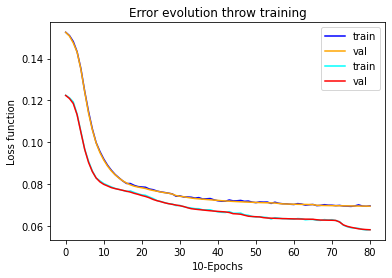

In [82]:
plt.plot(losses_train1,color="blue",label="train")
plt.plot(losses_val1,color="orange",label="val")  
plt.plot(losses_train2,color="cyan",label="train")
plt.plot(losses_val2,color="red",label="val")  
plt.title("Error evolution throw training")
plt.ylabel("Loss function")
plt.xlabel(f"{val_frequency}-Epochs")
plt.legend(loc="upper right")

print(f"Total epoch : {(len(losses_train)-1)*val_frequency}")

In [83]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model1.state_dict(),
            'losses_train': losses_train1,
            'losses_val': losses_val1
            }, "model/model1_autoencoder.m")
torch.save({
            'epoch': epoch,
            'model_state_dict': model2.state_dict(),
            'losses_train': losses_train2,
            'losses_val': losses_val2
            }, "model/model2_autoencoder.m")

## Encoder

In [26]:
model1 = Model1(2)
model2 = Model1(4)

checkpoint = torch.load("model/model1_autoencoder.m")
model1..(checkpoint['model_state_dict'])
epochs1 = checkpoint['epoch']
losses_train1 = checkpoint['losses_train']
losses_val1 = checkpoint['losses_val']

checkpoint = torch.load("model/model2_autoencoder.m")
model2.load_state_dict(checkpoint['model_state_dict'])
epochs2 = checkpoint['epoch']
losses_train2 = checkpoint['losses_train']
losses_val2 = checkpoint['losses_val']

In [50]:
class Encoder(nn.Module):
    
    def __init__(self,model):
        super().__init__()
        self.linear1 = model.linear1
        self.linear2 = model.linear2
    
    def forward(self,x):
        original_shape = x.shape
        x = x.view(-1,28*28)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

In [51]:
encoder1 = Encoder(model1)

In [52]:
(list(encoder1.parameters())[0] == list(model1.parameters())[0]).all()

tensor(True)

In [167]:
class RecoModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
        self.linear1 = nn.Linear(13*13*20,100) 
        self.linear2 = nn.Linear(100,10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.linear1(x.view(-1,13*13*20))
        x = self.linear2(x)
        return F.log_softmax(x,dim=1).max(dim=1)[1]

In [168]:
reco = RecoModel()
checkpoint = torch.load("model/model2.m")
reco.load_state_dict(checkpoint["model_state_dict"])


<All keys matched successfully>

In [169]:
_, (test_data, test_target) = next(enumerate(test_loader))

In [203]:
def show(data,model,reco,reco_bool=True):
    output =  model(data)
    if reco_bool:
        reco_value =  reco(output)
    output = output.detach().numpy()
    fig, axes = plt.subplots(max(len(data),2), 2, sharex=True, sharey=True,figsize=(15,15))

    for i in range(len(data)):
        axes[i,0].imshow(data[i][0],cmap ="gray") 
        axes[i,1].imshow(output[i][0],cmap ="gray") 
        if reco_bool:
            axes[i,1].set_title(f"digit reco: {reco_value[i]}")
        

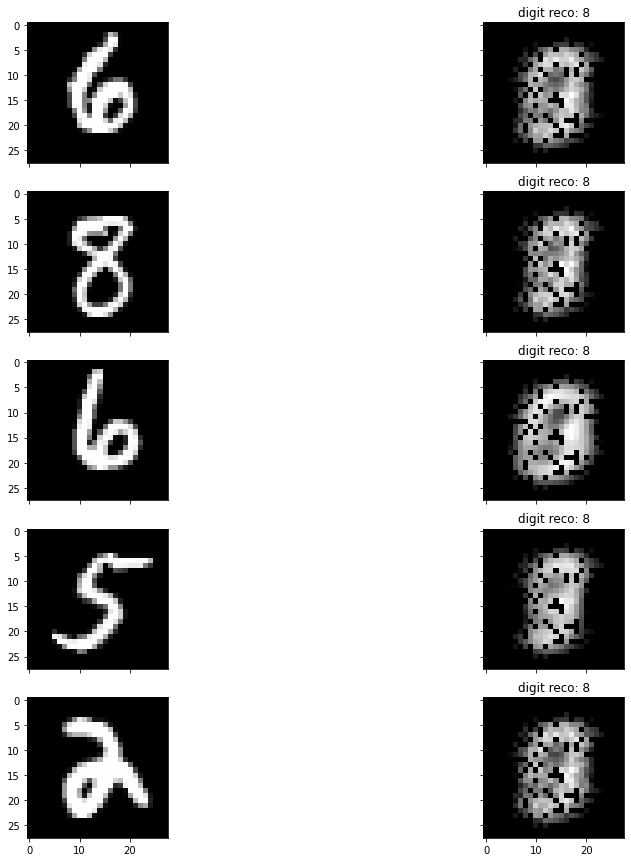

In [204]:
show(test_data[0:5],model1,reco)

In [211]:
output_test = model1(test_data)
reco_test = reco(output_test)
well_encoded_data_index = torch.where(reco_test==test_target)[0]
well_encoded_data = test_data[well_encoded_data_index]
well_encoded_digit = test_target[well_encoded_data_index]
len(well_encoded_data)/len(test_data)

0.2795

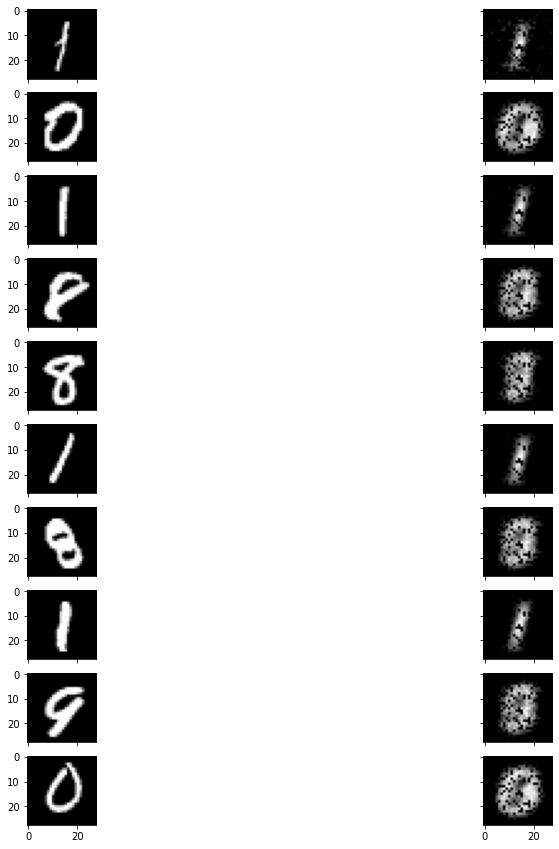

In [209]:
show(well_encoded_data[10:20],model1,None,reco_bool=False)

In [212]:
well_encoded_digit.unique()

tensor([0, 1, 5, 8, 9])